In [1]:
from IPython.display import HTML, display

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Hide/Show code."></form''')

In [2]:
#Constants

import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from datetime import datetime

def autolabel(ax,rects,floor):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*(height-(abs(floor)//21)),
                '%d' % int(height),
                ha='center', va='bottom')
        
date_form = DateFormatter("%b-%y")

colours = ['dodgerblue','darkslategrey','rebeccapurple','orchid']


In [3]:
#Create DataFrames to work with
urlp = 'https://raw.githubusercontent.com/WillAmor/CFS-public/master/CFS%20Pending.csv'
dfp = pd.read_csv(urlp) 
dfp['ReportDate'] = pd.to_datetime(dfp['ReportDate'])

urle = 'https://raw.githubusercontent.com/WillAmor/CFS-public/master/CFS%20Events.csv'
dfe = pd.read_csv(urle) 
dfe['ReportDate'] = pd.to_datetime(dfe['ReportDate'])

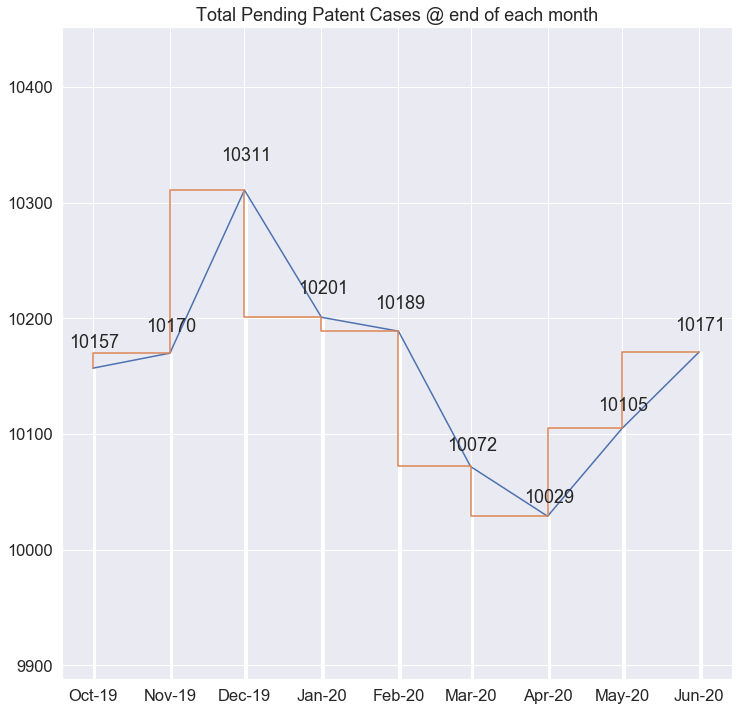

,Total_Cases
ReportDate,
2019-10-31,10157
2019-11-30,10170
2019-12-31,10311
2020-01-31,10201
2020-02-29,10189
2020-03-31,10072
2020-04-30,10029
2020-05-31,10105
2020-06-30,10171


In [4]:
# Fig 1 - Total Pending
sns.set(font_scale=1.5, style="darkgrid")
fig1, ax = plt.subplots(figsize=(12,12))

y = dfp['Total_Cases'].groupby(dfp['ReportDate']).sum()
x = y.index.map(lambda z: datetime(z.year, z.month, 1))
ax.plot(x,y)
ax.step(x,y)
bar = ax.bar(x,y,color='w', width=1, align='edge')
ax.set(title='Total Pending Patent Cases @ end of each month')
ax.xaxis.set_major_formatter(date_form)

low = min(y)
high = max(y)
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
autolabel(ax,bar,plt.ylim()[0])
plt.show()

df_Total = dfp[['ReportDate','Total_Cases']].groupby(['ReportDate']).sum().to_html()
display(HTML(df_Total))


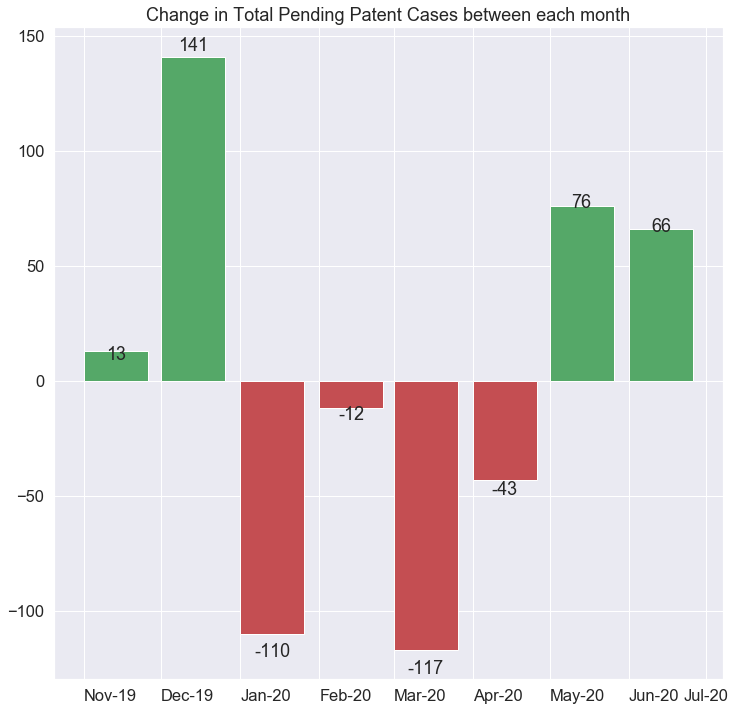

,Totals_Change
ReportDate,
2019-11-30,13.0
2019-12-31,141.0
2020-01-31,-110.0
2020-02-29,-12.0
2020-03-31,-117.0
2020-04-30,-43.0
2020-05-31,76.0
2020-06-30,66.0


In [5]:
#    Fig 2 - Change in Pending/Month
fig2, ax = plt.subplots(figsize=(12,12))                                        
tChange = dfp[['Total_Cases']].diff(periods=4)
dfp.loc[:, 'Totals_Change'] = tChange['Total_Cases']
y = dfp['Totals_Change'].groupby(dfp['ReportDate']).sum()
y = y[1:]
x = y.index.map(lambda z: datetime(z.year, z.month, 1))
c = [ 'r' if i < 0 else 'g' for i in y]
bar = ax.bar(x,y,color=c, width=25, align='edge')
ax.set_title('Change in Total Pending Patent Cases between each month')
ax.set_xticklabels(x,ha='left')
ax.xaxis.set_major_formatter(date_form)
autolabel(ax,bar,plt.ylim()[0])
plt.show()
df_Totalx = dfp[['ReportDate','Totals_Change']].groupby(['ReportDate']).sum()
tbl_Total = df_Totalx[1:].to_html()
display(HTML(tbl_Total))

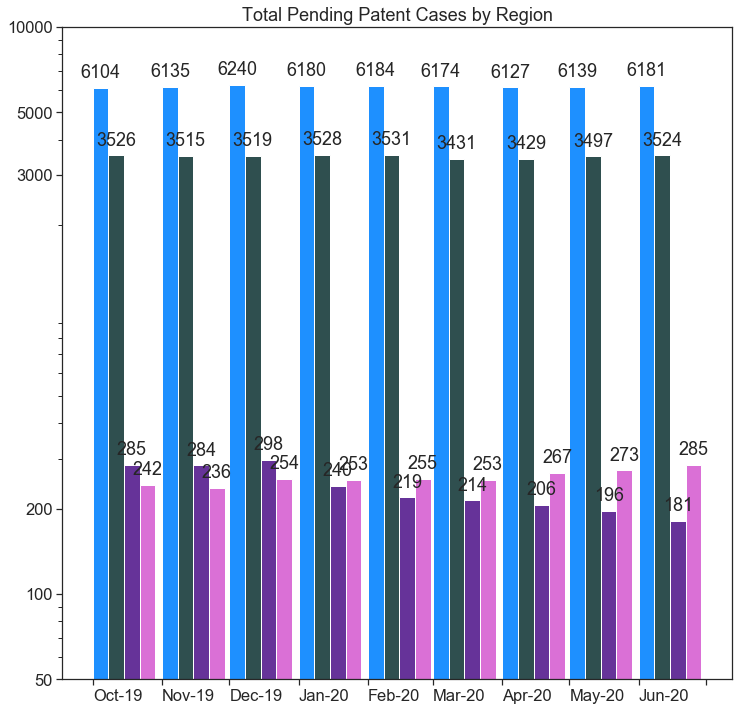

Region,EP,Foreign,GB,PCT
ReportDate,,,,
2019-10-31,6104,3526,285,242
2019-11-30,6135,3515,284,236
2019-12-31,6240,3519,298,254
2020-01-31,6180,3528,240,253
2020-02-29,6184,3531,219,255
2020-03-31,6174,3431,214,253
2020-04-30,6127,3429,206,267
2020-05-31,6139,3497,196,273
2020-06-30,6181,3524,181,285


In [6]:
#    Fig 3 - Breakdown of Pending Patents
sns.set(font_scale=1.5, style="ticks")
fig3, ax = plt.subplots(figsize=(12,12))
df_Region = dfp.pivot(index='ReportDate', columns='Region', values='Total_Cases')
bwidth = 7

for i, region in enumerate(df_Region[:]):
    y = df_Region[region]
    x = y.index.map(lambda z: datetime(z.year, z.month, 1+i*bwidth))
    bar=ax.bar(x,y,color=colours[i],width=bwidth,align='edge')
    autolabel(ax,bar,plt.ylim()[0])
    
ax.set(yscale='log',title='Total Pending Patent Cases by Region')
ax.set_xticklabels(x,ha='left')
ax.xaxis.set_major_formatter(date_form)
ax.set_yticks([50,100,200,3000,5000,10000])
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.setp(ax.get_xticklabels()[-1], visible=False)
plt.show()
tbl_Region = df_Region.to_html()
display(HTML(tbl_Region))

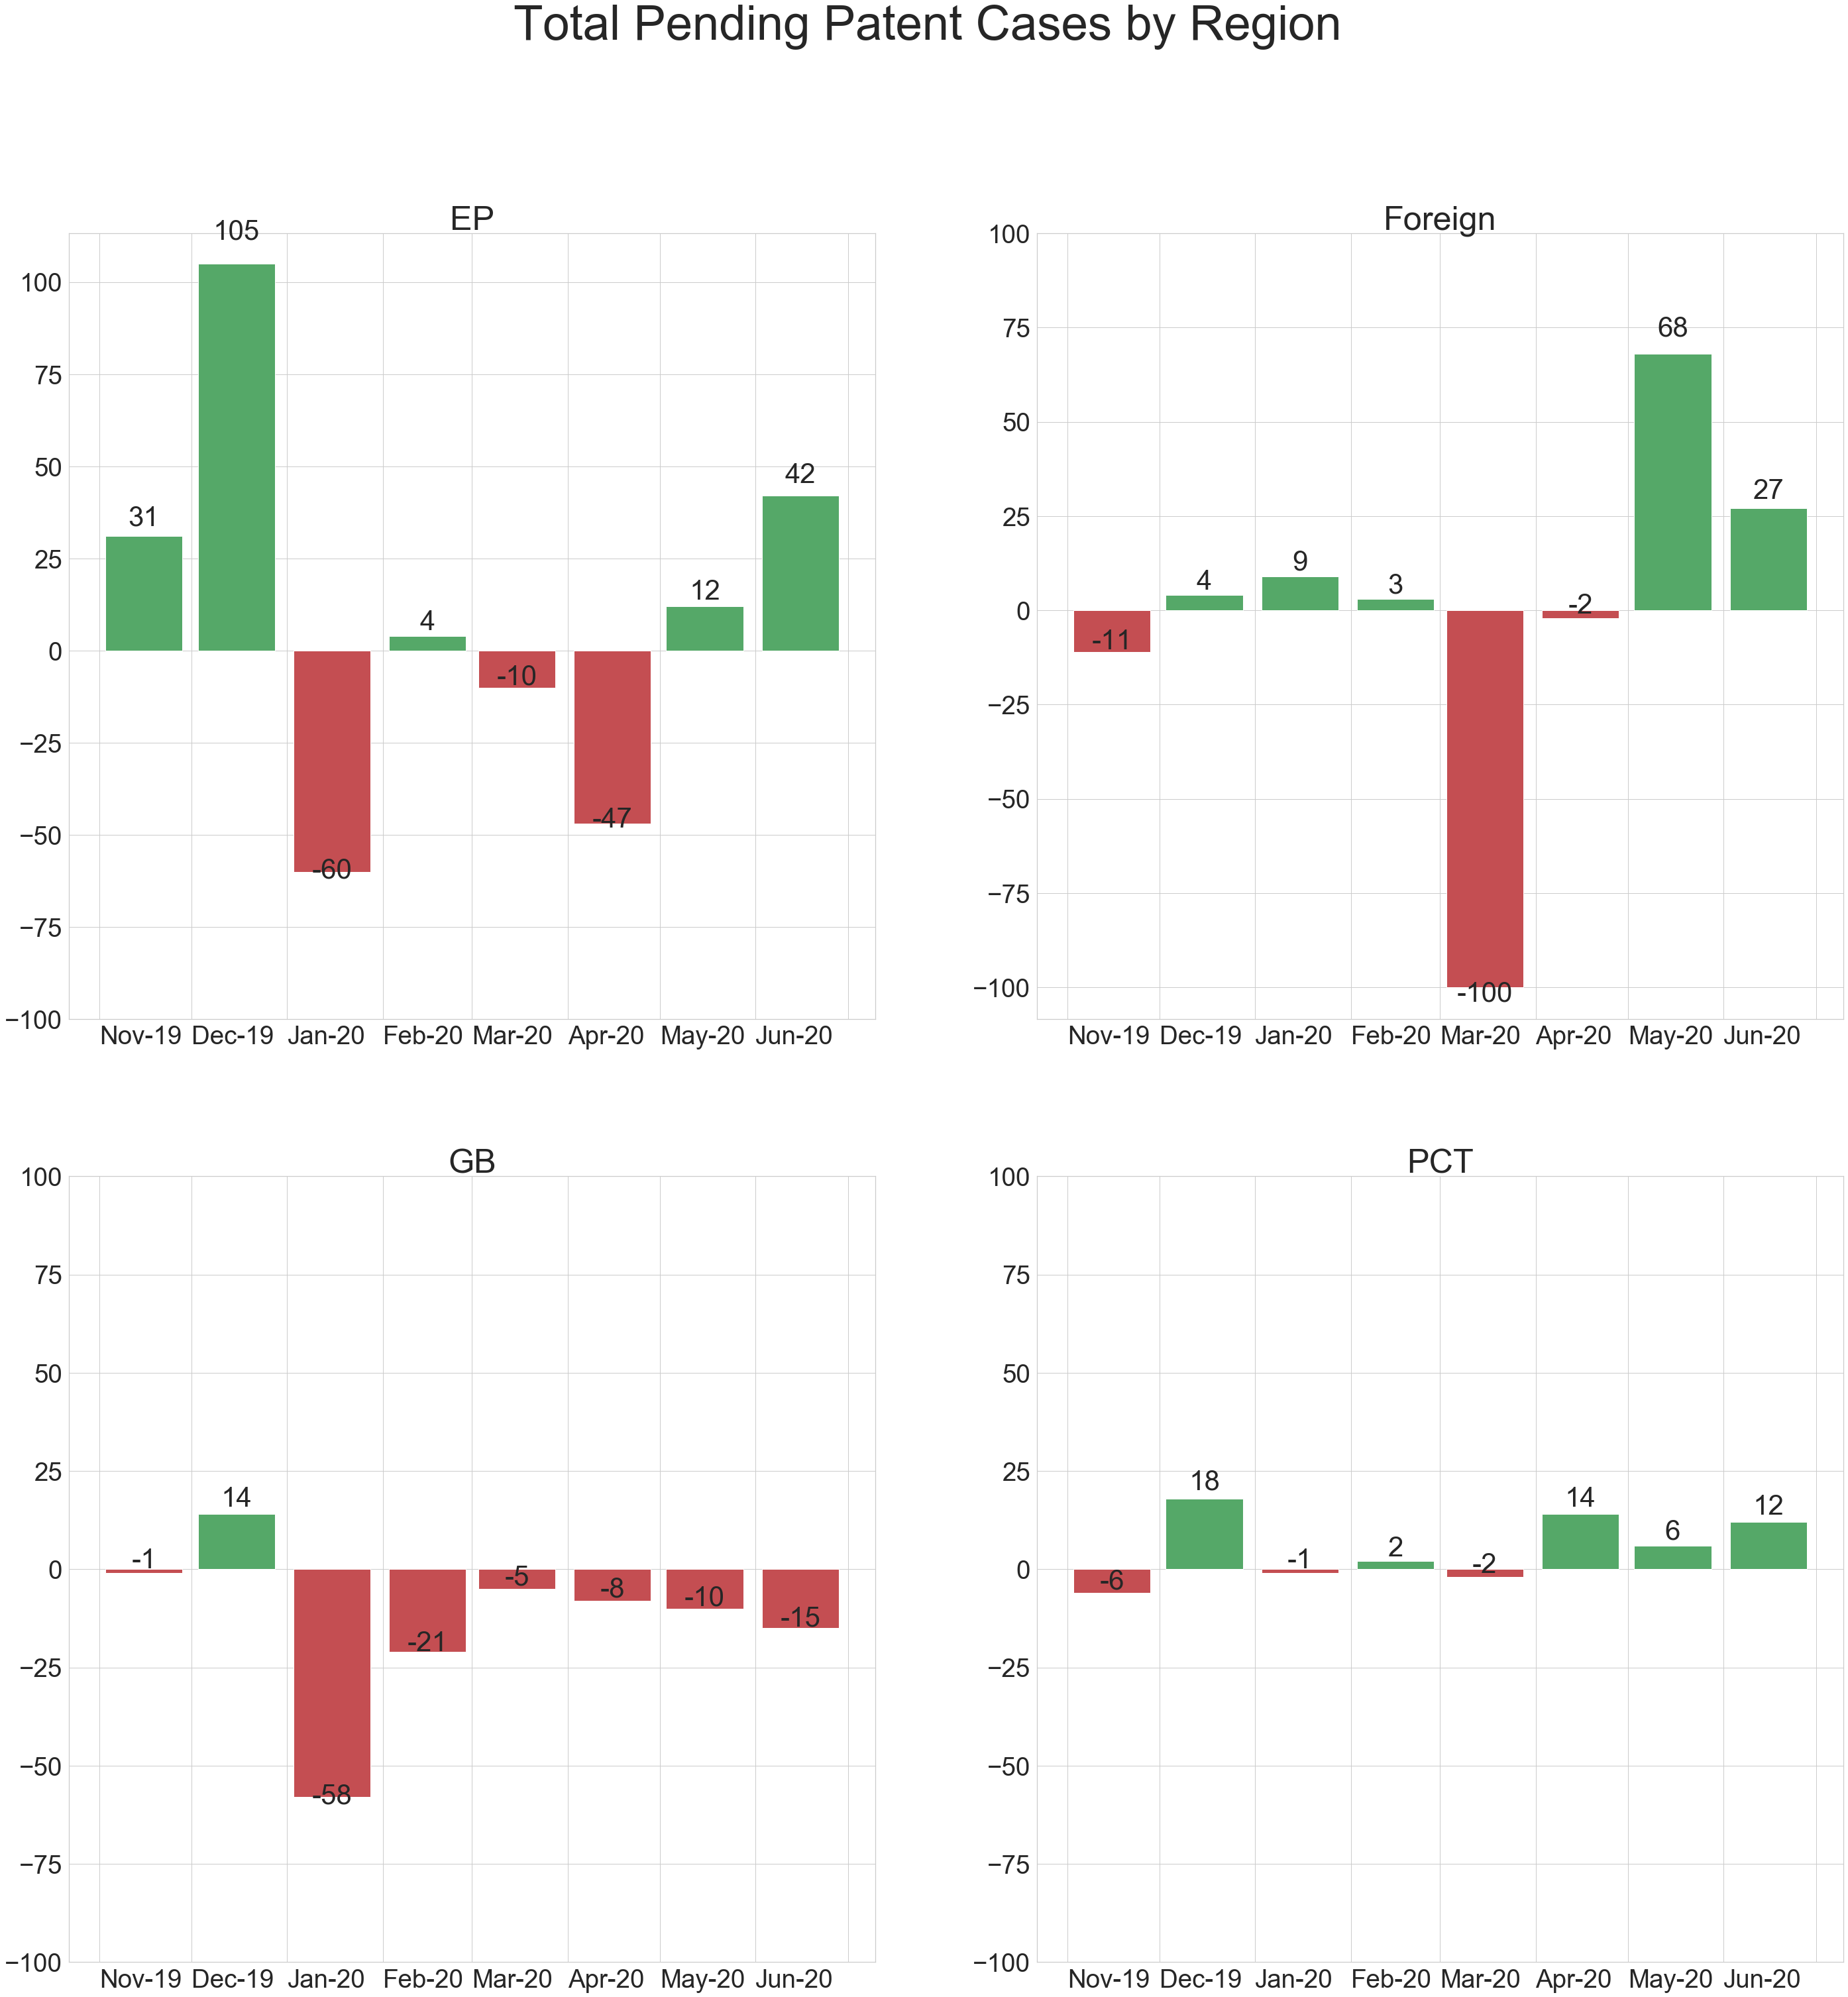

Region,EP,Foreign,GB,PCT
ReportDate,,,,
2019-11-30,31.0,-11.0,-1.0,-6.0
2019-12-31,105.0,4.0,14.0,18.0
2020-01-31,-60.0,9.0,-58.0,-1.0
2020-02-29,4.0,3.0,-21.0,2.0
2020-03-31,-10.0,-100.0,-5.0,-2.0
2020-04-30,-47.0,-2.0,-8.0,14.0
2020-05-31,12.0,68.0,-10.0,6.0
2020-06-30,42.0,27.0,-15.0,12.0


In [7]:
#   Fig 4 - Breakdown of Pending Patents - Change per Month
sns.set(font_scale=3.5, style="whitegrid")
fig, axs = plt.subplots(2,2, figsize=(48,48))
df_Change = dfp.pivot(index='ReportDate', columns='Region', values='Totals_Change')
fig.suptitle('Total Pending Patent Cases by Region', size='xx-large')

for i, region in enumerate(df_Change[:]):
    y = df_Change[region]
    y = y[1:]
    x = y.index.map(lambda z: datetime(z.year, z.month, 3))
    c = [ 'r' if j < 0 else 'g' for j in y]
    bar = axs[i//2,i%2].bar(x,y,color=c, width=25, align='edge')
    axs[i//2,i%2].set_title(region,size='large')
    autolabel(axs[i//2,i%2],bar,plt.ylim()[0])
    
for ax in axs.flat:    
    ax.set_xticklabels(x,ha='left')
    ax.xaxis.set_major_formatter(date_form)
    ax.set_yticks([-100,-75,-50,-25,0,25,50,75,100])
    plt.setp(ax.get_xticklabels()[-1], visible=False)

plt.show()
tbl_Change = df_Change[1:].to_html()
display(HTML(tbl_Change))

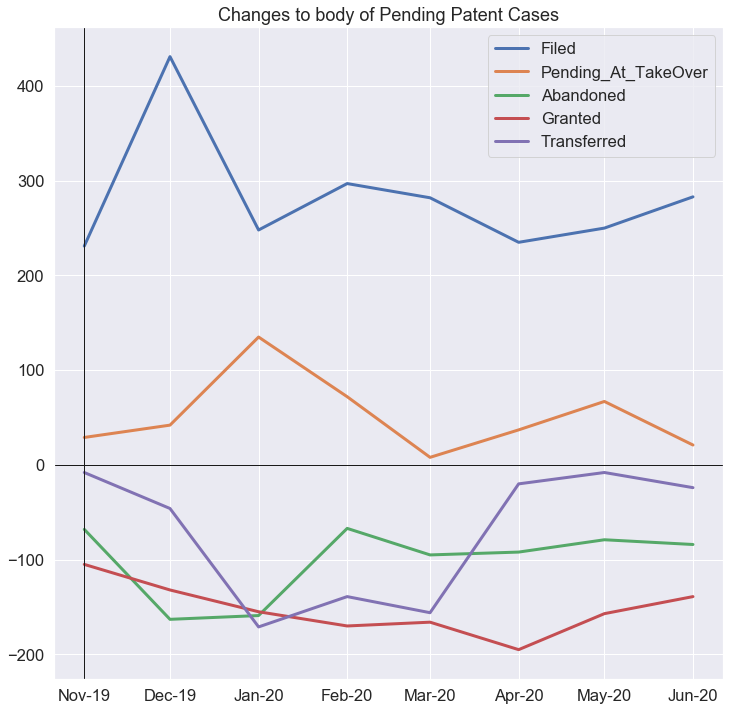

,Filed,Pending_At_TakeOver,Abandoned,Granted,Transferred
ReportDate,,,,,
2019-11-30,231.0,29.0,-68.0,-105.0,-8.0
2019-12-31,431.0,42.0,-163.0,-132.0,-46.0
2020-01-31,248.0,135.0,-159.0,-155.0,-171.0
2020-02-29,297.0,72.0,-67.0,-170.0,-139.0
2020-03-31,282.0,8.0,-95.0,-166.0,-156.0
2020-04-30,235.0,37.0,-92.0,-195.0,-20.0
2020-05-31,250.0,67.0,-79.0,-157.0,-8.0
2020-06-30,283.0,21.0,-84.0,-139.0,-24.0


In [8]:
#    Fig 5 - 
sns.set(font_scale=1.5, style="darkgrid")
fig, ax = plt.subplots(figsize=(12,12))
df_Events = dfe[['ReportDate','Filed','Pending_At_TakeOver','Abandoned','Granted','Transferred']].groupby(['ReportDate']).sum()
eChangeAdd = df_Events[['Filed','Pending_At_TakeOver']].diff(axis=0)
eChangeMinus = df_Events[['Abandoned','Granted','Transferred']].diff(periods=-1).shift(1)
df_EventsChange = df_Events
df_EventsChange.loc[:, ['Filed','Pending_At_TakeOver']] = eChangeAdd
df_EventsChange.loc[:, ['Abandoned','Granted','Transferred']] = eChangeMinus

for i, event in enumerate(df_EventsChange):
    y = df_EventsChange[event]
    y = y[1:]
    x = y.index.map(lambda z: datetime(z.year, z.month, 1))
    g = np.gradient(y[1:-1])
    if np.count_nonzero(g) != 0:
        ax.plot(x,y,label=event,lw=3)
    ax.axvline(x=x[0],lw=1,c='k')
    ax.axhline(lw=1,c='k')

ax.set(title='Changes to body of Pending Patent Cases')
ax.xaxis.set_major_formatter(date_form)
plt.legend(loc='upper right')
plt.show()
tbl_Events = df_EventsChange[1:].to_html()
display(HTML(tbl_Events))